# Testing against ED - Hubbard on a ring

In this example we use the [pyALF](https://git.physik.uni-wuerzburg.de/ALF/pyALF) interface to run ALF with the Mz choice of Hubbard Stratonovitch  transformation on a four site ring, at $U/t=4$  and inverse temperature $\beta t = 2$.  For this set of parameters, the exact  internal energy reads:   
$$
 \left\langle -t \sum_{\langle i,j\rangle, \sigma} \hat{c}_{i,\sigma}^{\dagger} \hat{c}_{j,\sigma}^{\phantom\dagger}   +  U  \sum_{i=1}^{N} \hat{n}_{i,\uparrow}\hat{n}_{j,\downarrow}  \right\rangle  =   -1.47261997 t 
$$
 
To reproduce this result we will have to carry out a systematic $\Delta \tau t$ extrapolation keeping $\Delta \tau t L_\text{Trotter} = 2$  constant.   
Recall that  the formulation of the auxiliary field QMC approach is based on the Trotter decomposition 
$$
e^{ -\Delta \tau \left( \hat{A} + \hat{B} \right) }  =  e^{ -\Delta \tau \hat{A}/2}  e^{ -\Delta \tau  \hat{B}  }   e^{ -\Delta \tau \hat{A}/2}  +  \mathcal{O} \left (\Delta  \tau^3\right)
$$
The overall error produced by this approximation is of the order $\Delta \tau^2$.  

Bellow we go through the steps for performing this extrapolation: setting the simulation parameters, running it and analyzing the data.

---

**1.** Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF, as well as mathematics and plotting packages:

In [1]:
import os
from py_alf import Simulation            # Interface with ALF

import numpy as np                       # Numerical library
from scipy.optimize import curve_fit     # Numerical library
import matplotlib.pyplot as plt          # Plotting library

$$
V_{U}(i) = U \hat{n}_{i,\uparrow}\hat{n}_{j,\downarrow}
$$
$$
V_{U,{\rm SUN}}(i) = \frac{U}{2}\left[
                    \sum_{\sigma=\uparrow,\downarrow} \left( \hat{n}_{i,\sigma}-\frac{1}{2} \right)
                  \right]^2 
                = \frac{U}{2} \left( 2\hat{n}_{i,\uparrow}\hat{n}_{j,\downarrow}
                                     - \hat{n}_{i,\uparrow}
                                     - \hat{n}_{j,\downarrow}
                                     + 1 \right)
$$
With $\langle \hat{n}_{i,\uparrow} \rangle = \langle \hat{n}_{i,\downarrow} \rangle = \frac{1}{2}$
$$
\left\langle V_{U,{\rm SUN}}(i) \right\rangle = \left\langle V_{U}(i) \right\rangle
$$


$$
V_{U,{\rm MZ}}(i) = \frac{U}{2} \left( \hat{n}_{i,\uparrow} - \hat{n}_{i,\downarrow} \right)^2
               = \frac{U}{2} \left( 2\hat{n}_{i,\uparrow}\hat{n}_{i,\downarrow} 
                                    - \hat{n}_{i,\uparrow} - \hat{n}_{i,\downarrow} \right)
$$
With $\langle \hat{n}_{i,\uparrow} \rangle = \langle \hat{n}_{i,\downarrow} \rangle = \frac{1}{2}$
$$
\left\langle V_{U,{\rm MZ}}(i) \right\rangle = \left\langle V_{U}(i) \right\rangle - \frac{U}{2}
$$

In [2]:
def extrapolate_dtau(ham_name, sim_dict, dtaus, do_ED):
    sims = []
    for i, dtau in enumerate(dtaus):
        print(dtau)
        sim_dict['Dtau'] = dtau
        if i == 0 and do_ED:
            sim_dict['do_ED'] = True
        else:
            sim_dict['do_ED'] = False
        sim = Simulation(ham_name, sim_dict, 
                         alf_dir=os.getenv('ALF_DIR', './ALF'),
                         branch='136-automatic-ed-form-op_t-and-op_v'
                        )
        if i == 0:
            sim.compile(target=ham_name)  
        sim.run()
        sims.append(sim)
    
    if do_ED:
        with open('{}/ED_Energy'.format(sims[0].sim_dir), 'r') as f:
            E = float(f.read())
    else:
        E = None
        
    ener = np.empty((len(sims), 2))
    for i, sim in enumerate(sims):
        print(sim.sim_dir)                   # Directory containing the simulation output
        sim.analysis()                       # Perform default analysis
        ener[i] = sim.get_obs(['Ener_scalJ'])['Ener_scalJ']['obs']  # Store internal energy
    
    return ener, E

In [ ]:
dtaus = np.array([0.05, 0.1, 0.2])
ener, E = extrapolate_dtau(
    'Hubbard',                       # Hamiltonian
    {                                # Model and simulation parameters for each Simulation instance
    'Model': 'Hubbard',              #    Base model
    'Lattice_type': 'N_leg_ladder',  #    Lattice type
    'L1': 4,                         #    Lattice length in the first unit vector direction
    'L2': 1,                         #    Lattice length in the second unit vector direction
    'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
    'Symm': True,                    #    Whether symmetrization takes place
    'ham_T': 1.0,                    #    Hopping parameter
    'ham_U': 4.0,                    #    Hubbard interaction
    'ham_Tperp': 0.0,                #    For bilayer systems
    'beta': 2.0,                     #    Inverse temperature
    'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
    'NSweep': 1000,                  #    Number of sweeps per bin
    'NBin': 100,                     #    Number of bins
    'Mz': True,                      #    If true, sets the M_z-Hubbard model: Nf=2, N_sum=1,
    'do_ED': True,
    },                               #             HS field couples to z-component of magnetizatio
    dtaus,
    do_ED=True
    )

0.05
Checking out branch 136-automatic-ed-form-op_t-and-op_v
Compiling ALF... Done.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Mz=True_Dtau=0.05" for Monte Carlo run.
Resuming previous run.
Run /home/jonas/Programs/ALF/Prog/Hubbard.out


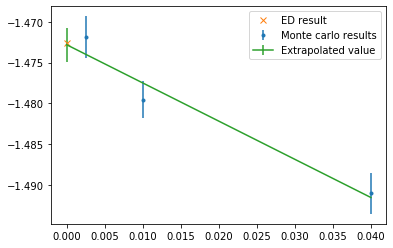

In [4]:
L1 = 4
L2 = 1
U = 4.0
E += L1*L2*U/2

plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1], fmt='.', label="Monte carlo results")
plt.plot(0, E, 'x', label='ED result')

def func(x, y0, a):
    return y0 + a*x**2
popt, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
xs = np.linspace(0., dtaus.max())
p = plt.plot(xs**2, func(xs, *popt))

plt.errorbar(0, popt[0], perr[0], label="Extrapolated value", color=p[0].get_color())
plt.legend()

In [8]:
dtaus = np.array([0.05, 0.1, 0.2])
ener, E = extrapolate_dtau(
    'Hubbard',                       # Hamiltonian
    {                                # Model and simulation parameters for each Simulation instance
    'Model': 'Hubbard',              #    Base model
    'Lattice_type': 'N_leg_ladder',  #    Lattice type
    'L1': 4,                         #    Lattice length in the first unit vector direction
    'L2': 1,                         #    Lattice length in the second unit vector direction
    'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
    'Symm': True,                    #    Whether symmetrization takes place
    'ham_T': 1.0,                    #    Hopping parameter
    'ham_U': 4.0,                    #    Hubbard interaction
    'ham_Tperp': 0.0,                #    For bilayer systems
    'beta': 2.0,                     #    Inverse temperature
    'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
    'NSweep': 1000,                  #    Number of sweeps per bin
    'NBin': 300,                     #    Number of bins
    'Mz': False,                      #    If true, sets the M_z-Hubbard model: Nf=2, N_sum=1,
    'do_ED': True,
    },                               #             HS field couples to z-component of magnetizatio
    dtaus,
    do_ED=True
    )

0.05
Compiling ALF... Done.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Mz=False_Dtau=0.05" for Monte Carlo run.
Resuming previous run.
Run /home/jonas/Programs/ALF/Prog/Hubbard.out
0.1
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Mz=False_Dtau=0.1" for Monte Carlo run.
Resuming previous run.
Run /home/jonas/Programs/ALF/Prog/Hubbard.out
0.2
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Mz=False_Dtau=0.2" for Monte Carlo run.
Resuming previous run.
Run /home/jonas/Programs/ALF/Prog/Hubbard.out
/home/jonas/Programs/pyALF/Notebooks/ALF_data/Hubbard_N_leg_ladder_L1=4_L2=1_Checkerboard=False_Symm=True_T=1.0_U=4.0_Tperp=0.0_beta=2.0_Mz=False_Dtau=0.05
Analysing Pa

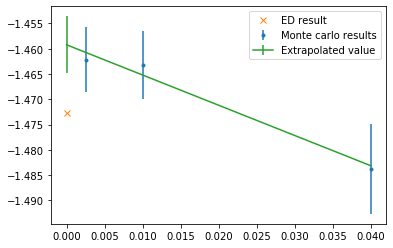

In [9]:
plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1], fmt='.', label="Monte carlo results")
plt.plot(0, E, 'x', label='ED result')

def func(x, y0, a):
    return y0 + a*x**2
popt, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
xs = np.linspace(0., dtaus.max())
p = plt.plot(xs**2, func(xs, *popt))

plt.errorbar(0, popt[0], perr[0], label="Extrapolated value", color=p[0].get_color())
plt.legend()

In [10]:
dtaus = np.array([0.05, 0.1, 0.2])
ener, E = extrapolate_dtau(
    'tV',                       # Hamiltonian
    {                                # Model and simulation parameters for each Simulation instance
    'Model': 'tV',              #    Base model
    'L1': 4,                         #    Lattice length in the first unit vector direction
    'L2': 1,                         #    Lattice length in the second unit vector direction
    'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
    'NSweep': 1000,                  #    Number of sweeps per bin
    'NBin': 100,                     #    Number of bins
    },                               #             HS field couples to z-component of magnetizatio
    dtaus,
    do_ED=True
    )

0.05
Compiling ALF... Done.
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/tV_L1=4_L2=1_Dtau=0.05" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/tV.out
0.1
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/tV_L1=4_L2=1_Dtau=0.1" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/tV.out
0.2
Prepare directory "/home/jonas/Programs/pyALF/Notebooks/ALF_data/tV_L1=4_L2=1_Dtau=0.2" for Monte Carlo run.
Create new directory.
Run /home/jonas/Programs/ALF/Prog/tV.out
/home/jonas/Programs/pyALF/Notebooks/ALF_data/tV_L1=4_L2=1_Dtau=0.05
Analysing Part_scal
Analysing Kin_scal
Analysing Ener_scal
Analysing Pot_scal
Analysing SpinZ_eq
Analysing Green_eq
Analysing Den_eq
/home/jonas/Programs/pyALF/Notebooks/ALF_data/tV_L1=4_L2=1_Dtau=0.05/Ener_scalJ 1
/home/jonas/Programs/pyALF/Notebooks/ALF_data/tV_L1=4_L2=1_Dtau=0.1
Analysing Part_scal
Analysing Kin_scal
Analysing Ener_scal
Analysing Pot_scal
Analysing SpinZ_e

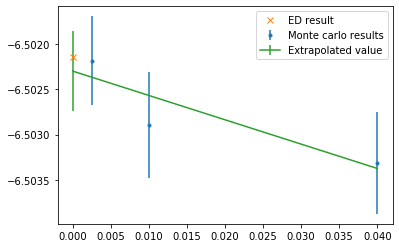

In [11]:
plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1], fmt='.', label="Monte carlo results")
plt.plot(0, E, 'x', label='ED result')

def func(x, y0, a):
    return y0 + a*x**2
popt, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
xs = np.linspace(0., dtaus.max())
p = plt.plot(xs**2, func(xs, *popt))

plt.errorbar(0, popt[0], perr[0], label="Extrapolated value", color=p[0].get_color())
plt.legend()